<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 5px; height: 70px">

## Notebook 3: Bot Trials

#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import keyboard as kb
from torch import load, tensor, no_grad
import matplotlib.pyplot as plt
import capstone_library as cl
import pyKey as pk

from windowcapture import WindowCapture
from model_class import CNN

#### Importing models
We first import the 3 models for our 3 opponent Pokemon. Each model is appended to a `models` dictionary, which allows us to call the appropriate model using the Pokemon's name as index.

In [2]:
models = {}
for mon in cl.opponents:
    models[mon] = CNN()
    models[mon].load_state_dict(load('../model/{}.pth'.format(mon)))
    models[mon].eval()

#### Initialising `WindowCapture` objects
Similar to the data collection section, we intialise `WindowCapture` objects for the battle scene and the enemy portrait.

In [3]:
# Initialise WindowCapture
# Make sure the game window is open first!
wincap = WindowCapture('pkmncc_09')
portcap = WindowCapture('pkmncc_09',portrait=True)

### The Blaziken Bot
___

We summarise the behaviour of our bot below:

- Repeatedly capture the battle scene and portrait area using the `WindowCapture` objects in a while loop.

- If there is no enemy detected in the portrait area, mash `j` every 0.5 seconds. This helps the bot navigate in-game menus.

- When an enemy is detected in the portrait area, begin performing predictions and inputs.

    - Take the latest screenshot obtained from `wincap.getscreenshot()`.
    
    - Use the `modelpredict` function to convert the image array to an appropriate tensor format and perform a prediction using the model. The model selected is based on the opponent Pokemon detected.

    - Using the `cl.keypress` function, translate the array into appropriate keyboard inputs to execute within the game.

    - Wait 0.15 seconds.

These steps are repeated in a while loop until the process is terminated by the user.

#### The keypress function
The `keypress` function is a shared function from the `capstone_library.py` file. We summarise the behaviour of the function here:

- Check to press left or right (`a` or `d`) by comparing the prediction values for both and performing the higher predicted option. (If the values are within 0.05 of each other, remain neutral instead.)

- Check if the bot is jumping or crouching (`SPACEBAR` or `s`) by comparing both values to a specified threshold.

- Check if the bot is attacking by comparing the `isattack` predicted value with a specified threshold.

    - If the bot is attacking, compare the 3 predicted values for `j`, `k` and `l` and perform the attack corresponding with the highest predicted value.

In [4]:
# Defining a function to convert the input array to the correct format, then perform and output precicted tensor
def modelpredict(model, img):
    X = np.float32(np.array(img/255.0))
    X = np.expand_dims(X, axis=0)
    X = tensor(X).permute(0, 3, 1, 2)
    with no_grad():
        output = model(X)
    return output

# Defining a gunction to print only once upon opponent detection
def printname(mon):
    print('{} detected.'.format(mon))
    return True

In [5]:
# Function to carry out all bot processess
def runbot():
    printed = False
    while True:
        screenshot = wincap.get_screenshot()[50:,:]
        portshot = portcap.get_screenshot()
        
        # Only performs predictions when a known enemy pokemon portrait is detected
        mon = cl.portraitcheck(portshot)
        if mon:
            if not printed:
                printed = printname(mon)
            # Perform prediction using the appropriate model
            array = modelpredict(models[mon], screenshot)
            # Perform appropriate keypress based on output predicted array
            cl.keypress(array, mon)

        # Mash 'j' if no enemy detected
        else:
            pk.press('j', sec=0.5)
            printed = False

        time.sleep(0.15)

        if kb.is_pressed('q'):
            cl.keyrelease()
            print('Bot has been stopped. Press e again to start bot.')
            return

#### Running the bot
Execute the code block below to begin running the bot. While the code block is running, we can perform the following commands using keyboard inputs:

- `e`: Starts the bot
- `q`: Stops the bot
- `ESC`: Breaks the code loop

Make sure to keep the game window in focus when running the bot, otherwise the bot will perform keyboard inputs outside of the game.

In [ ]:
print('Press e to start bot, then press q to quit.')
while True:
    if kb.is_pressed('e'):
        print('Running bot... Press q to quit')
        runbot()
        print('Pres ESC to end script.')
    if kb.is_pressed('esc'):
        break

You may also use the `botscript.py` script to run the bot.
___

#### Setting prediction thresholds

After running the bot, it may be observed that the bot does not perform specific inputs. To improve the performance of the bot, we can monitor the historic predictions of the bot over the course of a match, and adjust our prediction thresholds accordingly. We do so by appending the predictions to a list, which can then be observed on a lineplot.

When observing the prediction history, the code block below is run instead of the one above.

In [ ]:
# Initialise lists to append data to
space, a, s, d, isattack = [], [], [], [], []

while True:
    screenshot = wincap.get_screenshot()[50:,:]
    portshot = portcap.get_screenshot()

    # Only performs predictions when a known enemy pokemon portrait is detected
    mon = cl.portraitcheck(portshot)
    if mon:
        array = modelpredict(models[mon], screenshot)
        # Collect prediction for spacebar, a, s, d, and isattack
        cl.keypress(array, mon)
        space.append(array[0][0])
        a.append(array[0][1])
        s.append(array[0][2])
        d.append(array[0][3])
        isattack.append(array[0][7])
    
    time.sleep(0.15)

    if kb.is_pressed('q'):
        break

The `threshold` function below is used to visualise the historical prediction values for the following features: `SPACEBAR`, `a`, `s`, `d` and `isattack`. We do not monitor the values for `j`, `k` and `l`, as these actions are performed based on the `isattack` predicted value (as explained in the `keypress` section).

The function also draws a horizontal line based on the theshold defined during the function call, to help gauge an appropriate threshold for the prediction of the particular feature.

The thresholds are then updated in the `tdict` dictionary within `capstone_library.py`, to be used in the `keypress` function.

In [6]:
def threshold(name, reading, thresh):
    
    count = [x for x in reading if x < thresh]
    print('For "{}", {:.0f}% of instances have a prediction value below {}'.format(name, len(count)/len(reading)*100, thresh))
    plt.plot(reading, linewidth=1, label=name)
    plt.axhline(y=thresh)

For "SPACEBAR", 74% of instances have a prediction value below 0.12
For "s", 88% of instances have a prediction value below 0.23


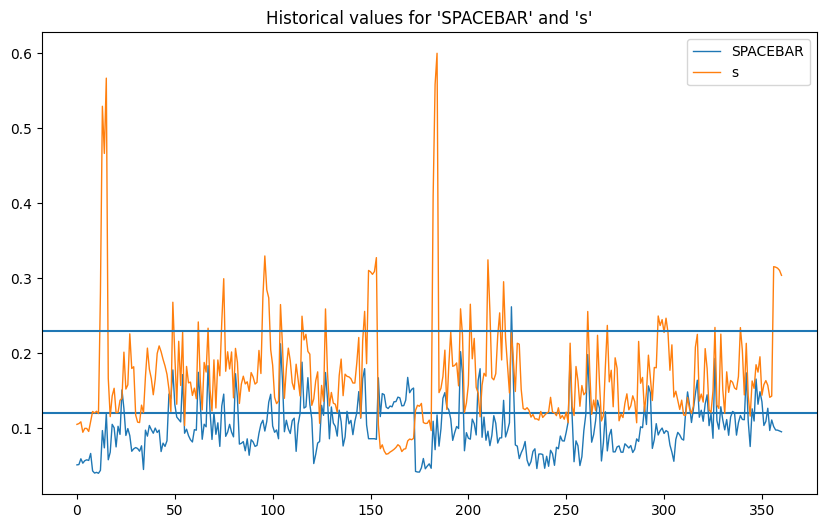

In [32]:
spacethresh = 0.12
sthresh = 0.23

plt.figure(figsize=(10,6))
plt.title("Historical values for 'SPACEBAR' and 's'")

threshold('SPACEBAR', space, spacethresh)
threshold('s', s, sthresh)

plt.legend(loc='best')
plt.show()

For "is attack", 50% of instances have a prediction value below 0.44


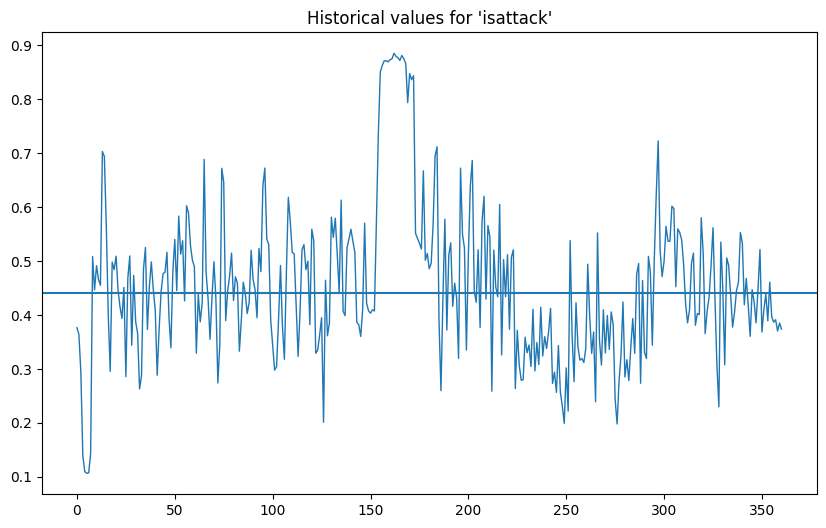

In [38]:
atkthresh = 0.44

plt.figure(figsize=(10,6))
plt.title("Historical values for 'isattack'")

threshold('is attack', isattack, atkthresh)
plt.show()

For "difference", 15% of instances have a prediction value below 0.05


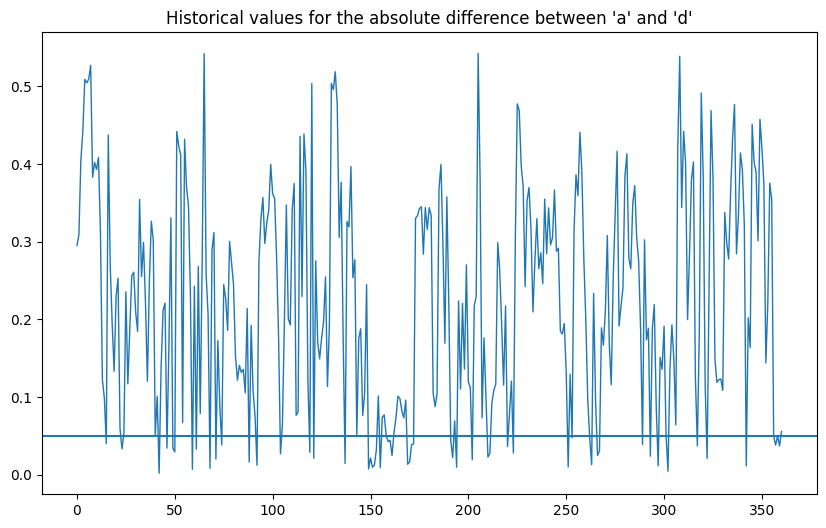

In [14]:
diff = [abs((aval-dval).item()) for aval, dval in zip(a,d)]
thresh = 0.05

plt.figure(figsize=(10,6))
plt.title("Historical values for the absolute difference between 'a' and 'd'")

threshold('difference', diff, thresh)

plt.show()


#### Assumptions and limitations
___

- A limitation for the data collection process is a lack of datapoints for specific scenarios due to the collection process. For example, the bot is unable to perform as well when cornered at the edge of the stage, due to a lack of datapoints in the training data in the corner. Bootstrapping such data will require more effort as we can only visually determine which datapoints fit this criteria.

- The bot is unable to perform actions that require a specific pattern of consecutive inputs, as it has no concept of historical information and only performs predictions based on the most recent screenshot.

- In the context of our problem statement, a key issue with the CNN model is the filesize of the trained model. Each model is approximately 900MB: it is unfeasible to implement this training method as it is for a standard video game with multiple different enemy types.

- Although individualised models help the bot to perform optimally and adapt based on the opponent detected, the models will perform poorly on other opponents as they are overfit on a particular opponent. A potential area to explore would be to train the model on all different enemies at once.


### Conclusions and future work
___

- To lower the filesize of the model, we can consider reducing the number of convlutional and linear layers, or reducing the dimensions of the input image. This may have adverse effects on the predictive ability of the model but can be explored as an area for improvement.

- As the data is already indexed by datetime, we can explore using a combination of a CNN and a Long Short-Term Memory Network (LSTM), so that our model can incorporate historical data for its predictions.